## Used Car Prediction

Main Objective : Predict selling price for car sellers

<img src="https://img.etimg.com/thumb/msid-106586397,width-300,height-225,imgsize-39324,resizemode-75/car-sales.jpg" />

In [43]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName('Used Car Prediction')
         .master('local[*]')
         .getOrCreate()
        )

In [44]:
# Set the legacy time parser policy on the existing Spark session
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [45]:
df = spark.read.format('csv').options(header=True, inferSchema=True).load('dataset/car_prices.csv').repartition(4)
df.show(30, truncate=50)

+----+-------------+----------------+--------------------+-----------+------------+-----------------+-----+---------+--------+--------+--------+---------------------------------------------+-----+------------+---------------------------------------+
|year|         make|           model|                trim|       body|transmission|              vin|state|condition|odometer|   color|interior|                                       seller|  mmr|sellingprice|                               saledate|
+----+-------------+----------------+--------------------+-----------+------------+-----------------+-----+---------+--------+--------+--------+---------------------------------------------+-----+------------+---------------------------------------+
|2009|     Chrysler|Town and Country|             Touring|    Minivan|   automatic|2a8hr54179r570758|   wi|      1.6| 90655.0|    gold|     tan|                        dt credit corporation| 8425|        7900|Wed Jan 21 2015 02:00:00 GMT-0800 (PST)|


# Preprocessing & Cleaning

In [46]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [47]:
# Count raw data
df.count()

558837

In [48]:
# Show all data
df.show()

+----+----------+----------------+--------------------+-----------+------------+-----------------+-----+---------+--------+--------+--------+--------------------+-----+------------+--------------------+
|year|      make|           model|                trim|       body|transmission|              vin|state|condition|odometer|   color|interior|              seller|  mmr|sellingprice|            saledate|
+----+----------+----------------+--------------------+-----------+------------+-----------------+-----+---------+--------+--------+--------+--------------------+-----+------------+--------------------+
|2009|  Chrysler|Town and Country|             Touring|    Minivan|   automatic|2a8hr54179r570758|   wi|      1.6| 90655.0|    gold|     tan|dt credit corpora...| 8425|        7900|Wed Jan 21 2015 0...|
|2007| Chevrolet|  Silverado 1500|          Work Truck|   Crew Cab|   automatic|2gcec13c971578282|   ca|     NULL|106732.0|    blue|   black|          auto plaza|13350|       14500|Thu Dec

In [49]:
# Count for missing values
df.select([count(when(isnan(c) | isnull(c),1)).alias(c) for c in df.columns]).show()

+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65353|  4|    0|    11794|      94|  749|     749|     0|  0|           0|       0|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



### Filling NULL Transmission

#### Case Casting (All to Lower)

In [50]:
df = df.withColumn("body", lower(df["body"]))
df = df.withColumn("make", lower(df["make"]))
df = df.withColumn("model", lower(df["model"]))
df.select(['body', 'make', 'model']).show()

+-------+----------+-------------+
|   body|      make|        model|
+-------+----------+-------------+
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|    suv|   mercury|  mountaineer|
|   NULL|oldsmobile|        ciera|
|  sedan|      ford|fusion energi|
|minivan|       ram|c/v cargo van|
+-------+----------+-------------+
only showing top 20 rows



#### Self-joining to fill transmission

In [51]:
# New df for joining
filled_df = df.dropna(subset=["transmission"])
filled_df.where(col('transmission').isNull()).show()

+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year|make|model|trim|body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



In [52]:
# Inner join to fill missing transmission values
df = df.alias("df").join(
    filled_df.alias("filled_df"),
    on=["year", "make", "model", "trim", "body"],
    how="inner"
).select(
    col("df.year"),
    col("df.make"),
    col("df.model"),
    col("df.trim"),
    col("df.body"),
    col("df.vin"),
    col("df.state"),
    col("df.condition"),
    col("df.odometer"),
    col("df.color"),
    col("df.interior"),
    col("df.seller"),
    col("df.mmr"),
    col("df.sellingprice"),
    col("df.saledate"),
    col("df.transmission").alias("original_transmission"),
    col("filled_df.transmission").alias("filled_transmission")
).distinct()

In [53]:
# Validating the filled transmission corresponds correctly
df.select(['year','make', 'model', 'trim', 'body', 'original_transmission', 'filled_transmission']).where(col('original_transmission').isNull()).groupBy(['year','make', 'model', 'trim', 'body', 'original_transmission', 'filled_transmission']).count().show(50)

+----+-------------+---------------+-----------+------------+---------------------+-------------------+-----+
|year|         make|          model|       trim|        body|original_transmission|filled_transmission|count|
+----+-------------+---------------+-----------+------------+---------------------+-------------------+-----+
|1992|        honda|         accord|         EX|       sedan|                 NULL|          automatic|    1|
|1992|        honda|         accord|         EX|       sedan|                 NULL|             manual|    1|
|1993|         ford|         escort|         LX|       wagon|                 NULL|          automatic|    1|
|1993|       toyota|          camry|         LE|       sedan|                 NULL|          automatic|    6|
|1994|         ford|         ranger|        XLT| regular cab|                 NULL|             manual|    1|
|1994|         ford|         ranger|        XLT| regular cab|                 NULL|          automatic|    1|
|1994|    

In [54]:
# Merging into one "transmission" column

df = df.withColumn(
    "transmission",
    when(col("original_transmission").isNotNull(), col("original_transmission")).otherwise(col("filled_transmission"))
).drop("original_transmission", "filled_transmission")

In [55]:
df.show()

+----+---------+---------+-------------+---------+-----------------+-----+---------+--------+--------+--------+--------------------+----+------------+--------------------+------------+
|year|     make|    model|         trim|     body|              vin|state|condition|odometer|   color|interior|              seller| mmr|sellingprice|            saledate|transmission|
+----+---------+---------+-------------+---------+-----------------+-----+---------+--------+--------+--------+--------------------+----+------------+--------------------+------------+
|1990|   jaguar|xj-series|XJ6 Sovereign|    sedan|sajhy174xlc607411|   ga|        2|135657.0|    blue|     tan|capital auto auction| 775|         550|Thu May 28 2015 0...|   automatic|
|1991|chevrolet| corvette|         Base|hatchback|1g1yy238xm5116736|   fl|        2| 91569.0|    blue|    gray|germain toyota of...|4900|        2400|Wed Jan 14 2015 0...|   automatic|
|1991|chevrolet| corvette|         Base|hatchback|1g1yy2384m5104212|   fl| 

#### More cleaning for the rest of the null columns 

In [56]:
df = df.where((df["transmission"] == "automatic") | (df["transmission"] == "manual"))
df = df.where((df["color"] != '—'))
df = df.where((df["interior"] != '—'))
df.select(['transmission', 'color', 'interior']).show()

+------------+--------+--------+
|transmission|   color|interior|
+------------+--------+--------+
|   automatic|    blue|     tan|
|   automatic|    blue|    gray|
|   automatic|     red|     red|
|   automatic|   white|   beige|
|   automatic|   white|   beige|
|   automatic|   white|    blue|
|   automatic|   white|    blue|
|   automatic|   beige|   beige|
|   automatic|   beige|   beige|
|   automatic|   white|    blue|
|   automatic|   white|    blue|
|   automatic|   white|    blue|
|   automatic|   white|    blue|
|   automatic|    gray|    gray|
|   automatic|    gray|    gray|
|   automatic|burgundy|    gray|
|   automatic|burgundy|    gray|
|      manual|burgundy|    gray|
|      manual|burgundy|    gray|
|   automatic|    blue|    blue|
+------------+--------+--------+
only showing top 20 rows



In [57]:
# Drop rows with missing values
df = df.dropna(subset=["year", "make", "model", "body", "condition", "transmission", "odometer", "color", "mmr"])
df = df.distinct()

#### Casting to its respective data types

In [75]:
# Cast to respective data types
df = df.withColumn('sellingprice', col('sellingprice').cast('double'))
df = df.withColumn('mmr', col('mmr').cast('double'))
df = df.withColumn('condition', col('condition').cast('double'))
df = df.withColumn('odometer', col('odometer').cast('integer'))

#### Count Each Categorical Value

In [59]:
# Count each categorical value
df.groupBy("make").count().sort("count").show()
df.groupBy("model").count().sort(desc("count")).show(30)
df.groupBy("body").count().sort(desc("count")).show()
df.groupBy("color").count().sort("count").show()
df.groupBy("interior").count().sort("count").show()
df.groupBy("transmission").count().sort("count").show()

24/06/21 21:08:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:08:35 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+-----+
|        make|count|
+------------+-----+
|       lotus|    1|
|      daewoo|    2|
| lamborghini|    3|
|      fisker|    9|
|    plymouth|   15|
| rolls-royce|   15|
|     ferrari|   16|
|         geo|   20|
|       tesla|   22|
|aston martin|   24|
|     bentley|  109|
|    maserati|  123|
|       isuzu|  173|
|  oldsmobile|  314|
|       smart|  375|
|        saab|  457|
|      hummer|  768|
|        fiat|  892|
|      suzuki|  999|
|      jaguar| 1313|
+------------+-----+
only showing top 20 rows



24/06/21 21:09:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:16 WARN RowBasedKeyValueBatch: Calling spill() on

+----------------+-----+
|           model|count|
+----------------+-----+
|          altima|18817|
|           f-150|13077|
|           camry|12022|
|          fusion|11194|
|          escape|10295|
|           focus| 9425|
|          accord| 8774|
|        3 series| 8015|
|          impala| 7521|
|   grand caravan| 7418|
|         corolla| 7339|
|         g sedan| 7118|
|           civic| 7111|
|           cruze| 6846|
|          sonata| 6802|
|         elantra| 6749|
|          malibu| 6685|
|          maxima| 6495|
|        explorer| 6439|
|  silverado 1500| 5969|
|town and country| 5687|
|          sentra| 5275|
|            edge| 5257|
|           rogue| 5217|
|         mustang| 4600|
|         equinox| 4568|
|          optima| 4455|
|           jetta| 4381|
|  grand cherokee| 4361|
|         c-class| 4341|
+----------------+-----+
only showing top 30 rows



24/06/21 21:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:09:57 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+------+
|        body| count|
+------------+------+
|       sedan|229512|
|         suv|134152|
|   hatchback| 24652|
|     minivan| 23739|
|       coupe| 16705|
|    crew cab| 15476|
|       wagon| 15292|
| convertible|  9729|
|   supercrew|  7985|
|     g sedan|  7118|
|    supercab|  5094|
| regular cab|  4784|
|         van|  4202|
|extended cab|  4195|
|    quad cab|  3996|
|e-series van|  1748|
|  double cab|  1532|
|     g coupe|  1483|
| crewmax cab|   526|
|    king cab|   495|
+------------+------+
only showing top 20 rows



24/06/21 21:10:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:10:39 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+------+
|    color| count|
+---------+------+
|     lime|    15|
|     pink|    38|
|turquoise|   220|
| charcoal|   469|
|   yellow|  1250|
|off-white|  1405|
|   purple|  1506|
|   orange|  1970|
|    brown|  6496|
| burgundy|  8572|
|    beige|  8655|
|     gold| 10355|
|    green| 10438|
|      red| 42154|
|     blue| 49203|
|   silver| 80342|
|     gray| 81164|
|    white|102325|
|    black|107845|
+---------+------+



24/06/21 21:11:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:19 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+------+
| interior| count|
+---------+------+
|   yellow|    19|
|   orange|   135|
| burgundy|   171|
|    green|   220|
|    white|   230|
|     gold|   298|
|   purple|   317|
|off-white|   342|
|     blue|  1010|
|   silver|  1035|
|      red|  1293|
|    brown|  7986|
|      tan| 40373|
|    beige| 56824|
|     gray|169008|
|    black|235161|
+---------+------+



24/06/21 21:11:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:11:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:12:01 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+------+
|transmission| count|
+------------+------+
|      manual| 32273|
|   automatic|482149|
+------------+------+



#### Body Type Categorization

In [13]:
# Body Type Categorization
df = df.withColumn(
    "body_type",
     when(col("body").like("%cab%"), "cab")
    .when(col("body").like("%suv%"), "suv")
    .when(col("body").like("%sedan%"), "sedan")
    .when(col("body").like("%hatchback%"), "hatchback")
    .when(col("body") == "minivan", "minivan")
    .when(col("body").like("%van%"), "van")
    .when(col("body") == "supercrew", "cab")
    .when(col("body").like("%coupe%"), "coupe")
    .when(col("body").like("%wagon%"), "wagon")
    .when(col("body").like("%convertible%"), "convertible")
    .when(col("body").like("%koup%"), "koup")
)
df.groupBy("body_type").count().sort(desc("count")).show()

24/06/20 23:59:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 23:59:20 WARN RowBasedKeyValueBatch: Calling spill() on

+-----------+------+
|  body_type| count|
+-----------+------+
|      sedan|236630|
|        suv|134152|
|        cab| 44714|
|  hatchback| 24652|
|    minivan| 23739|
|      coupe| 18866|
|      wagon| 15340|
|convertible| 10113|
|        van|  6025|
|       koup|   191|
+-----------+------+



In [16]:
# Count remaining data
df.count()

24/06/20 21:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/20 21:33:30 WARN RowBasedKeyValueBatch: Calling spill() on

514422

In [13]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- saledate: string (nullable = true)



In [80]:
df.summary().show()

24/06/21 09:11:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/06/21 09:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:12:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:12:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:12:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:12:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:12:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but re

+-------+------------------+------+-----------------+------------------+----------+-----------------+------+------------------+------------------+------+--------+--------------------+------------------+-----------------+--------------------+------------+---------+-------------------+------------------+-----------------+--------------------+
|summary|              year|  make|            model|              trim|      body|              vin| state|         condition|          odometer| color|interior|              seller|               mmr|     sellingprice|            saledate|transmission|body_type|     saledate_clean|       vehicle_age|   price_mmr_diff|             z_score|
+-------+------------------+------+-----------------+------------------+----------+-----------------+------+------------------+------------------+------+--------+--------------------+------------------+-----------------+--------------------+------------+---------+-------------------+------------------+-----------

In [15]:
df = df.filter(df.sellingprice > 1)
df.select('*').where(df.sellingprice <= 1).show()

+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year|make|model|trim|body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



# EDA

In [76]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- saledate: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- saledate_clean: string (nullable = true)
 |-- vehicle_age: integer (nullable = true)
 |-- price_mmr_diff: double (nullable = true)
 |-- z_score: double (nullable = true)



#### Average Car Price for each transmission

In [43]:
# Harga rata-rata per transmission
df.groupBy('transmission').agg(round(avg('mmr'), 2).alias('avg_mmr')).show()

+------------+--------+
|transmission| avg_mmr|
+------------+--------+
|   automatic|13918.45|
|      manual|11679.29|
+------------+--------+



#### Average Car Price for each body type

In [29]:
# Harga rata-rata per body_type
df.groupBy('body_type').agg(round(avg('mmr'), 2).alias('avg_mmr')).show()

+-----------+--------+
|  body_type| avg_mmr|
+-----------+--------+
|        van|15230.75|
|      wagon| 9993.74|
|    minivan|11456.85|
|      coupe|16239.33|
|        suv|16103.16|
|convertible|17669.69|
|       koup| 9768.79|
|      sedan|11859.07|
|  hatchback| 10092.7|
|        cab|18153.23|
+-----------+--------+



#### (MMR - Selling Price Average) Price per Transmission

In [42]:
# Selisih harga mmr dan selling price per transmission
df.groupBy('transmission').agg(round(avg(col('mmr') - col('sellingprice')),2).alias('avg_price_difference')).show()

+------------+--------------------+
|transmission|avg_price_difference|
+------------+--------------------+
|   automatic|              141.21|
|      manual|              278.43|
+------------+--------------------+



#### Total Car Count Each Year & Distribution Chart

In [57]:
# Jumlah mobil berdasarkan tahun
df.select('year').groupBy('year').count().sort('year').show(26)

+----+-----+
|year|count|
+----+-----+
|1990|   30|
|1991|   46|
|1992|   87|
|1993|  115|
|1994|  257|
|1995|  440|
|1996|  530|
|1997|  967|
|1998| 1379|
|1999| 2097|
|2000| 3229|
|2001| 4924|
|2002| 7325|
|2003| 9980|
|2004|13063|
|2005|16510|
|2006|20823|
|2007|24554|
|2008|26091|
|2009|17312|
|2010|21655|
|2011|38596|
|2012|79779|
|2013|80574|
|2014|62626|
|2015| 7414|
+----+-----+



In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

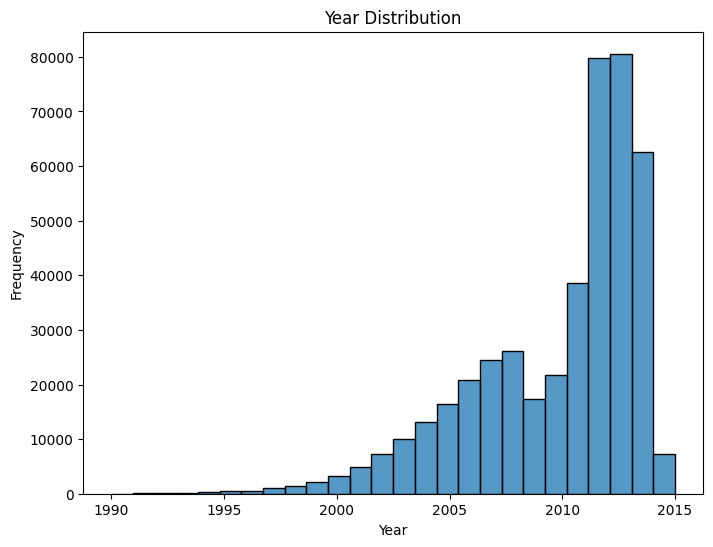

In [149]:
df_pd = df.select('year').toPandas()
plt.figure(figsize=(8, 6))
sns.histplot(data=df_pd, x='year', bins=26)
plt.title('Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.show()

#### Finding Vehicle Age

In [60]:
df_2 = df.withColumn('saledate_clean', regexp_replace(col('saledate'), ' GMT.*', ''))

In [61]:
# Convert the cleaned date string to a timestamp and then to a date
df_2 = df_2.withColumn('saledate_clean', from_unixtime(unix_timestamp(col('saledate_clean'), 'EEE MMM dd yyyy HH:mm:ss')))

# Calculate vehicle_age
df_2 = df_2.withColumn('vehicle_age', year(col('saledate_clean')) - col('year'))

In [62]:
df_2.select('year', 'saledate_clean').where(col('year') > year(col('saledate_clean'))).count()

166

In [63]:
# Merging cleaned date in df_2 to original df
df = df_2.filter(col('year') <= year(col('saledate_clean')))

In [64]:
df.select(['year', year(col('saledate_clean')), 'vehicle_age']).sort('year').show()

24/06/21 21:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:14:30 WARN RowBasedKeyValueBatch: Calling spill() on

+----+--------------------+-----------+
|year|year(saledate_clean)|vehicle_age|
+----+--------------------+-----------+
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2014|         24|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2015|         25|
|1990|                2014|         24|
|1990|                2015|         25|
|1990|                2015|         25|
+----+--------------------+-----------+
only showing top 20 rows



#### Average Vehicle Age per Year

In [150]:
df.groupBy('year').agg(avg('vehicle_age').alias('avg_vehicle_age')).sort('year').show()

+----+------------------+
|year|   avg_vehicle_age|
+----+------------------+
|1990|              24.9|
|1991|23.869565217391305|
|1992|22.816091954022987|
|1993|21.904347826086955|
|1994|20.894941634241246|
|1995| 19.87272727272727|
|1996| 18.88867924528302|
|1997|17.890382626680456|
|1998|  16.9108049311095|
|1999|15.901287553648068|
|2000|14.906472592133788|
|2001|13.908813972380178|
|2002|12.900750853242322|
|2003| 11.90941883767535|
|2004|10.907218862435888|
|2005| 9.910054512416718|
|2006| 8.907602170676656|
|2007| 7.909709212348294|
|2008| 6.912421907937603|
|2009| 5.907116451016636|
+----+------------------+
only showing top 20 rows



## Correlation Matrix

In [44]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

In [161]:
indexers_cor = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(df) for col in ["make", "model", "transmission", "color", "body_type"]]
pipeline = Pipeline(stages=indexers_cor)
cor_df = pipeline.fit(df).transform(df)
cor_df.show()

+----+-------------+---------------+---------------+---------+------------+-----------------+-----+---------+--------+--------+--------+--------------------+-----+------------+--------------------+---------+-------------------+-----------+--------+---------+----------------+---------+-------------+
|year|         make|          model|           trim|     body|transmission|              vin|state|condition|odometer|   color|interior|              seller|  mmr|sellingprice|            saledate|body_type|     saledate_clean|vehicle_age|make_idx|model_idx|transmission_idx|color_idx|body_type_idx|
+----+-------------+---------------+---------------+---------+------------+-----------------+-----+---------+--------+--------+--------+--------------------+-----+------------+--------------------+---------+-------------------+-----------+--------+---------+----------------+---------+-------------+
|2013|    chevrolet|          cruze|            1LT|    sedan|   automatic|1g1pc5sb9d7167061|   va| 

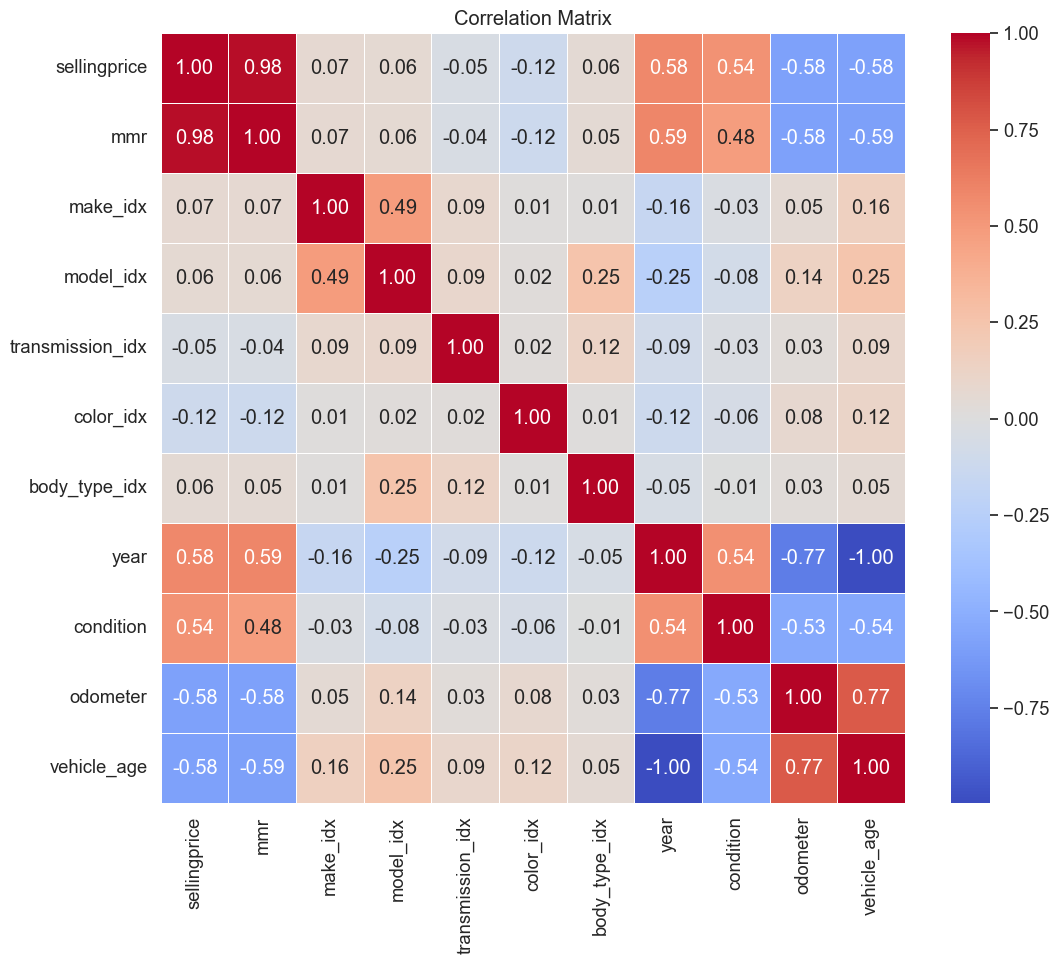

In [173]:
# Select relevant columns for correlation analysis
cols = [ "sellingprice", "mmr", "make_idx", "model_idx", "transmission_idx", "color_idx", "body_type_idx", "year", "condition", "odometer", "vehicle_age"]

# Generate the correlation matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
corr_matrix = cor_df.select(cols).toPandas().corr()
heatmap = sns.heatmap(data=corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# First Few Model-Making

In [24]:
# Feature Selection
features_df = df.select(["make", "model", "year", "body_type", "transmission", "condition", "odometer", "color", "interior","mmr"])
features_df.show()

+---------+---------+----+-----------+------------+---------+--------+--------+--------+----+
|     make|    model|year|  body_type|transmission|condition|odometer|   color|interior| mmr|
+---------+---------+----+-----------+------------+---------+--------+--------+--------+----+
|   jaguar|xj-series|1990|      sedan|   automatic|      2.0|  135657|    blue|     tan| 775|
|chevrolet| corvette|1991|  hatchback|   automatic|      2.0|   91569|    blue|    gray|4900|
|chevrolet| corvette|1991|  hatchback|   automatic|      2.0|  138310|     red|     red|4625|
|   toyota|    camry|1991|      sedan|   automatic|      2.0|   91780|   white|   beige| 550|
|   toyota|    camry|1991|      sedan|   automatic|      2.0|  232476|   white|    blue| 325|
|   toyota|    camry|1991|      sedan|   automatic|      1.0|  209809|   beige|   beige| 475|
|   toyota|    camry|1991|      sedan|   automatic|      3.0|  244226|   white|    blue| 300|
|   toyota|    camry|1991|      sedan|   automatic|      2.0

In [227]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

In [244]:
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(features_df) for col in ["make", "body_type", "model"]]
pipeline = Pipeline(stages=indexers)
features_df = pipeline.fit(features_df).transform(features_df)
features_df.show()

+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+
|      make|           model|year|body_type|transmission|condition|odometer| color|interior|  mmr|make_idx|body_type_idx|
+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+
|      ford|          fusion|2012|    sedan|   automatic|      3.1|   86927|   red|   black| 8150|     0.0|          0.0|
|    toyota|          sienna|2014|  minivan|   automatic|      4.4|   24913|  gray|    gray|21300|     3.0|          4.0|
| chevrolet|             hhr|2008|    wagon|   automatic|      4.2|   66269|  gold|   black| 5800|     1.0|          6.0|
|     honda|           civic|2012|    sedan|   automatic|      3.4|   35852|  blue|    gray|11050|     5.0|          0.0|
|      ford|          fiesta|2011|    sedan|   automatic|      4.7|   52164|silver|   black| 7300|     0.0|          0.0|
|    subaru|         out

In [245]:
assembler = VectorAssembler(
    inputCols=["make_idx", "body_type_idx", "year", "condition", "model_idx"],
    outputCol="features"
)
features_df = assembler.transform(features_df)
features_df.show(truncate=False)
#"sellingprice_idx", "transmission_idx", "color_idx"

+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+---------------------+
|make      |model           |year|body_type|transmission|condition|odometer|color |interior|mmr  |make_idx|body_type_idx|features             |
+----------+----------------+----+---------+------------+---------+--------+------+--------+-----+--------+-------------+---------------------+
|ford      |fusion          |2012|sedan    |automatic   |3.1      |86927   |red   |black   |8150 |0.0     |0.0          |[0.0,0.0,2012.0,3.1] |
|toyota    |sienna          |2014|minivan  |automatic   |4.4      |24913   |gray  |gray    |21300|3.0     |4.0          |[3.0,4.0,2014.0,4.4] |
|chevrolet |hhr             |2008|wagon    |automatic   |4.2      |66269   |gold  |black   |5800 |1.0     |6.0          |[1.0,6.0,2008.0,4.2] |
|honda     |civic           |2012|sedan    |automatic   |3.4      |35852   |blue  |gray    |11050|5.0     |0.0          |[5.0,0.0,2012.0

In [246]:
features_vector_df = features_df.select(['features','mmr'])
features_vector_df = features_vector_df.withColumn('mmr', features_vector_df['mmr'].cast(IntegerType()))
features_vector_df.show(truncate=False)

+---------------------+-----+
|features             |mmr  |
+---------------------+-----+
|[7.0,7.0,2012.0,4.2] |24200|
|[5.0,1.0,2011.0,3.5] |20300|
|[1.0,1.0,2008.0,2.8] |4275 |
|[19.0,1.0,2012.0,3.8]|25700|
|[1.0,0.0,2009.0,4.3] |6625 |
|[10.0,0.0,2012.0,4.7]|21000|
|[13.0,0.0,2008.0,3.4]|22400|
|[3.0,0.0,2013.0,4.4] |11350|
|[3.0,0.0,2010.0,2.1] |7150 |
|[14.0,0.0,2006.0,2.8]|3800 |
|[4.0,4.0,2014.0,3.0] |17250|
|[4.0,1.0,2005.0,3.0] |4075 |
|[5.0,4.0,2005.0,2.8] |4975 |
|[2.0,0.0,2011.0,2.0] |9525 |
|[2.0,0.0,2009.0,3.1] |4800 |
|[15.0,1.0,2008.0,2.9]|14050|
|[4.0,1.0,2004.0,1.9] |2125 |
|[0.0,1.0,2013.0,4.8] |19500|
|[10.0,0.0,2012.0,4.1]|28200|
|[0.0,0.0,2007.0,2.4] |3625 |
+---------------------+-----+
only showing top 20 rows



In [247]:
(trainData, testData) = features_vector_df.randomSplit([0.83, 0.17], seed=42)

In [248]:
trainData.show()

+--------------------+---+
|            features|mmr|
+--------------------+---+
|[0.0,0.0,1996.0,1.0]|500|
|[0.0,0.0,1996.0,1.0]|650|
|[0.0,0.0,1996.0,2.0]|575|
|[0.0,0.0,1996.0,2.0]|600|
|[0.0,0.0,1997.0,1.0]|350|
|[0.0,0.0,1997.0,1.9]|850|
|[0.0,0.0,1997.0,2.0]|675|
|[0.0,0.0,1997.0,2.4]|800|
|[0.0,0.0,1997.0,2.6]|650|
|[0.0,0.0,1997.0,2.7]|400|
|[0.0,0.0,1998.0,1.9]|375|
|[0.0,0.0,1998.0,1.9]|400|
|[0.0,0.0,1998.0,1.9]|400|
|[0.0,0.0,1998.0,2.0]|775|
|[0.0,0.0,1998.0,2.7]|850|
|[0.0,0.0,1999.0,1.0]|700|
|[0.0,0.0,1999.0,1.0]|700|
|[0.0,0.0,1999.0,1.0]|750|
|[0.0,0.0,1999.0,1.9]|575|
|[0.0,0.0,1999.0,1.9]|600|
+--------------------+---+
only showing top 20 rows



### Random Forest

In [20]:
# Import classification models
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression

In [254]:
rf = RandomForestRegressor(labelCol="mmr", featuresCol="features", maxBins=761).fit(trainData)

In [255]:
predictedDataRF = rf.transform(testData)
predictedDataRF.show()

+--------------------+----+------------------+
|            features| mmr|        prediction|
+--------------------+----+------------------+
|[0.0,0.0,1996.0,2.0]| 475|2452.7270896570267|
|[0.0,0.0,1997.0,1.7]| 575|2452.7270896570267|
|[0.0,0.0,1997.0,2.0]| 600|2452.7270896570267|
|[0.0,0.0,1997.0,2.8]| 375| 2956.218436159469|
|[0.0,0.0,1998.0,2.8]| 650| 2956.218436159469|
|[0.0,0.0,1999.0,1.9]| 450|2452.7270896570267|
|[0.0,0.0,1999.0,3.1]| 775|3401.1134240433844|
|[0.0,0.0,2000.0,1.9]|1050|2452.7270896570267|
|[0.0,0.0,2000.0,2.0]| 650|2452.7270896570267|
|[0.0,0.0,2000.0,2.0]|1100|2452.7270896570267|
|[0.0,0.0,2000.0,2.0]|1500|2452.7270896570267|
|[0.0,0.0,2000.0,2.5]| 375|2452.7270896570267|
|[0.0,0.0,2000.0,3.8]|1175| 4253.009498145293|
|[0.0,0.0,2001.0,1.9]| 800|2452.7270896570267|
|[0.0,0.0,2001.0,2.0]| 800|2452.7270896570267|
|[0.0,0.0,2002.0,1.0]| 725|2585.5071572717084|
|[0.0,0.0,2002.0,1.9]|6275|2585.5071572717084|
|[0.0,0.0,2002.0,2.1]| 725|2585.5071572717084|
|[0.0,0.0,200

### Linear Regression

In [78]:
lr = LinearRegression(labelCol="mmr", featuresCol="features").setMaxIter(100)

In [239]:
# Fit the LinearRegression model to the training data
lrModel = lr.fit(trainData)

# Use the trained model to make predictions on the test data
predictedDataLR = lrModel.transform(testData)

# Show the predicted data
predictedDataLR.show()

24/05/23 23:35:47 WARN Instrumentation: [f4161af3] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+----+-------------------+
|            features| mmr|         prediction|
+--------------------+----+-------------------+
|[0.0,1.0,2.0,1997...|1050|  -8388.49006060278|
|[0.0,1.0,2.0,1997...|2400|  -8388.49006060278|
|[0.0,1.0,2.0,1997...|1475| -8181.722684533335|
|[0.0,1.0,2.0,1998...|1150| -8939.722815691493|
|[0.0,1.0,2.0,1998...|1875| -7078.816431066487|
|[0.0,1.0,2.0,1999...|2075| -5769.142801529728|
|[0.0,1.0,2.0,2000...|1850| -2598.562787368428|
|[0.0,1.0,2.0,2001...|4000|-3149.7955424566753|
|[0.0,1.0,2.0,2001...|4100|-3149.7955424566753|
|[0.0,1.0,2.0,2001...|2875|  -2943.02816638723|
|[0.0,1.0,2.0,2001...|4275|  -2943.02816638723|
|[0.0,1.0,2.0,2001...|3475|-1702.4239099705592|
|[0.0,1.0,2.0,2002...|2300|-3701.0282975453883|
|[0.0,1.0,2.0,2002...|2525|-1840.1219129203819|
|[0.0,1.0,2.0,2002...|2650|-1633.3545368509367|
|[0.0,1.0,2.0,2003...|3450| -530.4482833836228|
|[0.0,1.0,2.0,2003...|4200|  89.85384482471272|
|[0.0,1.0,2.0,2003...|7775|  296.6212208

### Gradient Boosted

In [256]:
gbt = GBTRegressor(labelCol="mmr", featuresCol="features", maxBins = 60)

In [257]:
# Fit the LinearRegression model to the training data
gbtModel = gbt.fit(trainData)

# Use the trained model to make predictions on the test data
predictedDataGBT = gbtModel.transform(testData)

# Show the predicted data
predictedDataGBT.show()

+--------------------+----+------------------+
|            features| mmr|        prediction|
+--------------------+----+------------------+
|[0.0,0.0,1996.0,2.0]| 475|  732.991696439143|
|[0.0,0.0,1997.0,1.7]| 575|  732.991696439143|
|[0.0,0.0,1997.0,2.0]| 600|  732.991696439143|
|[0.0,0.0,1997.0,2.8]| 375| 1067.655733620657|
|[0.0,0.0,1998.0,2.8]| 650| 1067.655733620657|
|[0.0,0.0,1999.0,1.9]| 450| 956.5840226142152|
|[0.0,0.0,1999.0,3.1]| 775|1470.4757644780334|
|[0.0,0.0,2000.0,1.9]|1050|1078.7264770768213|
|[0.0,0.0,2000.0,2.0]| 650|1078.7264770768213|
|[0.0,0.0,2000.0,2.0]|1100|1078.7264770768213|
|[0.0,0.0,2000.0,2.0]|1500|1078.7264770768213|
|[0.0,0.0,2000.0,2.5]| 375|1126.3941036340664|
|[0.0,0.0,2000.0,3.8]|1175|1899.0523753395898|
|[0.0,0.0,2001.0,1.9]| 800| 1252.107958904391|
|[0.0,0.0,2001.0,2.0]| 800| 1252.107958904391|
|[0.0,0.0,2002.0,1.0]| 725|1559.4482241833864|
|[0.0,0.0,2002.0,1.9]|6275|1559.4482241833864|
|[0.0,0.0,2002.0,2.1]| 725|1607.1158507406312|
|[0.0,0.0,200

# Model Evaluation

In [198]:
# Import evaluation models

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


### Random Forest

In [258]:
evaluator1 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictedDataRF)
mse = evaluator2.evaluate(predictedDataRF)
r2 = evaluator3.evaluate(predictedDataRF)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 5058.197210360737
Mean Squared Error (MSE) 25585359.01890114
R-squared (R²) 0.711080482132586


In [259]:
predictions = predictedDataRF.withColumn("ape", abs((col("mmr") - col("prediction")) / col("mmr")))
mape = predictions.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 38.90868814537291%


### Linear Regression

In [240]:
evaluator1 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictedDataLR)
mse = evaluator2.evaluate(predictedDataLR)
r2 = evaluator3.evaluate(predictedDataLR)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 7032.623407311401
Mean Squared Error (MSE) 49457791.98906422
R-squared (R²) 0.4353174422038686


In [241]:
predictions = predictedDataLR.withColumn("ape", abs((col("mmr") - col("prediction")) / col("mmr")))
mape = predictions.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 66.41334733512191%


### Gradient Boosted

In [260]:
evaluator1 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="mmr", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictedDataGBT)
mse = evaluator2.evaluate(predictedDataGBT)
r2 = evaluator3.evaluate(predictedDataGBT)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 4487.275016381302
Mean Squared Error (MSE) 20135637.07263981
R-squared (R²) 0.7726207964999593


In [261]:
predictions = predictedDataGBT.withColumn("ape", abs((col("mmr") - col("prediction")) / col("mmr")))
mape = predictions.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 28.664560693914527%


# Final Model (GBT Regressor)

In [65]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

# Import classification models
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

### Filtering Outliers (using z-score)

In [66]:
from pyspark.sql.functions import abs, col, mean, stddev

df = df.withColumn("price_mmr_diff", abs(col("sellingprice") - col("mmr")))

mean_diff = df.select(mean(col("price_mmr_diff"))).collect()[0][0]
stddev_diff = df.select(stddev(col("price_mmr_diff"))).collect()[0][0]

threshold = 2

df = df.withColumn("z_score", (col("price_mmr_diff") - mean_diff) / stddev_diff)
df_filtered = df.filter(col("z_score") <= threshold)

df_filtered = df_filtered.drop("price_mmr_diff", "z_score")

df_filtered.show()

24/06/21 21:16:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:16:44 WARN RowBasedKeyValueBatch: Calling spill() on

+----+---------+---------+-------------+---------+-----------------+-----+---------+--------+--------+--------+--------------------+------+------------+--------------------+------------+-------------------+-----------+
|year|     make|    model|         trim|     body|              vin|state|condition|odometer|   color|interior|              seller|   mmr|sellingprice|            saledate|transmission|     saledate_clean|vehicle_age|
+----+---------+---------+-------------+---------+-----------------+-----+---------+--------+--------+--------+--------------------+------+------------+--------------------+------------+-------------------+-----------+
|1990|   jaguar|xj-series|XJ6 Sovereign|    sedan|sajhy174xlc607411|   ga|      2.0|  135657|    blue|     tan|capital auto auction| 775.0|       550.0|Thu May 28 2015 0...|   automatic|2015-05-28 05:30:00|         25|
|1991|chevrolet| corvette|         Base|hatchback|1g1yy2384m5104212|   fl|      2.0|  138310|     red|     red|autonation to

### Cutting Data Where Year < 2000

In [67]:
# Cutting Data Where Year < 2000
df_filtered = df_filtered.filter(df_filtered.year > 1999)

In [68]:
# Checking
df_filtered.select('*').where(df.year < 2000).show()

+----+----+-----+----+----+---+-----+---------+--------+-----+--------+------+---+------------+--------+------------+--------------+-----------+
|year|make|model|trim|body|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|transmission|saledate_clean|vehicle_age|
+----+----+-----+----+----+---+-----+---------+--------+-----+--------+------+---+------------+--------+------------+--------------+-----------+
+----+----+-----+----+----+---+-----+---------+--------+-----+--------+------+---+------------+--------+------------+--------------+-----------+



In [69]:
# Count after filtering outliers
df_filtered.count()

24/06/21 21:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:18:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:18:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:18:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:18:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


490312

In [70]:
df_filtered.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- saledate: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- saledate_clean: string (nullable = true)
 |-- vehicle_age: integer (nullable = true)



In [71]:
df_filtered.show()

+----+----+--------+-----------+-----+-----------------+-----+---------+--------+------+--------+--------------------+------+------------+--------------------+------------+-------------------+-----------+
|year|make|   model|       trim| body|              vin|state|condition|odometer| color|interior|              seller|   mmr|sellingprice|            saledate|transmission|     saledate_clean|vehicle_age|
+----+----+--------+-----------+-----+-----------------+-----+---------+--------+------+--------+--------------------+------+------------+--------------------+------------+-------------------+-----------+
|2000|audi|      a4|2.8 quattro|sedan|waudh28d3ya188447|   ga|      1.9|  171217|silver|   beige|automobile accept...|1400.0|       900.0|Thu Feb 05 2015 0...|   automatic|2015-02-05 02:00:00|         15|
|2000|audi|      a4|2.8 quattro|sedan|waudh28d2ya045151|   wa|      2.0|  144741| black|   beige|   lexus of bellevue|1525.0|      2000.0|Wed Jan 21 2015 0...|      manual|2015-01-

### 4 Features (w year)

In [25]:
features_df = df_filtered.select(["condition", "odometer", "mmr", "year", "sellingprice"])
features_df.show()

# Define weights for each feature
weights = {
    "condition": 0.7,
    "odometer": 0.5,
    "mmr": 1.5,
    "year": 0.7
}

# Apply weights to the relevant features
for feature, weight in weights.items():
    features_df = features_df.withColumn(feature, col(feature) * weight)

# Assemble the weighted features into a single feature vector
assembler = VectorAssembler(
    inputCols=["condition", "odometer", "mmr", "year"],
    outputCol="features"
)

# Split the data into training and test sets
(trainData, testData) = features_df.randomSplit([0.83, 0.17], seed=42)

# # Cache the training data if it is not already cached
# def cache_if_not_cached(df):
#     if df.storageLevel == StorageLevel.NONE:
#         df.cache()
#     return df

# trainData = cache_if_not_cached(trainData)

# Set up the Gradient-Boosted Trees model
print("Setting up Gradient-Boosted Trees model...")
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="sellingprice",
    seed=42
)

# Set up a pipeline with the assembler and GBTRegressor
print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, gbt])

# Create parameter grid for CrossValidator
print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Set up CrossValidator
print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

# Fit the model using cross-validation
print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+---------+--------+----+----+------------+
|condition|odometer| mmr|year|sellingprice|
+---------+--------+----+----+------------+
|      2.0|  135657| 775|1990|         550|
|      2.0|  138310|4625|1991|        2700|
|      2.0|   91569|4900|1991|        2400|
|      2.0|  252591| 300|1991|         150|
|      3.0|  244226| 300|1991|         500|
|      1.0|  189563| 425|1991|         300|
|      2.0|  175381| 425|1991|         300|
|      2.0|  264816| 275|1991|         200|
|      1.0|  209809| 475|1991|         250|
|      2.0|   91780| 550|1991|         550|
|      2.0|  232476| 325|1991|         300|
|      2.0|  210619| 375|1991|         400|
|      2.0|  199195| 450|1991|         200|
|      3.0|   14372|9025|1992|       13700|
|      1.0|  162000| 500|1992|         900|
|      1.0|  160933| 650|1992|         850|
|      1.0|  238417| 675|1992|         250|
|      3.0|  109999| 525|1992|         400|
|      1.0|  206841| 675|1992|         475|
|      1.0|  206841| 675|1992|  

In [72]:
# Extract the best model
bestModel = cvModel.bestModel

# Make predictionsq
predictions = bestModel.transform(testData)

In [73]:
predictions.show()

+---------+--------+-----+-----------+------------+--------------------+--------------------+------------------+
|condition|odometer|  mmr|vehicle_age|sellingprice|            features|     scaled_features|        prediction|
+---------+--------+-----+-----------+------------+--------------------+--------------------+------------------+
|      1.0|       1| 2875|         13|         600|[1.0,1.0,2875.0,1...|[1.09179334051766...| 659.1198622611458|
|      1.0|       1| 3900|         14|         500|[1.0,1.0,3900.0,1...|[1.09179334051766...| 1339.208856716215|
|      1.0|   11007|11450|          1|        8400|[1.0,11007.0,1145...|[1.09179334051766...| 8841.785337613757|
|      1.0|   15625|16300|          0|       13000|[1.0,15625.0,1630...|[1.09179334051766...|13923.304707904368|
|      1.0|   17609|14800|          1|       12100|[1.0,17609.0,1480...|[1.09179334051766...|12724.894264081091|
|      1.0|   27030|13700|          2|       10000|[1.0,27030.0,1370...|[1.09179334051766...|109

In [74]:
predictions_sorted = predictions.orderBy(desc("sellingprice"), desc("prediction"))
predictions_sorted.show(50)

24/06/21 09:01:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:01:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:01:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:01:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+---------+--------+------+-----------+------------+--------------------+--------------------+------------------+
|condition|odometer|   mmr|vehicle_age|sellingprice|            features|     scaled_features|        prediction|
+---------+--------+------+-----------+------------+--------------------+--------------------+------------------+
|      4.6|   12116|182000|          4|      183000|[4.6,12116.0,1820...|[5.02224936638125...| 50526.16535510918|
|      4.3|    5593|155000|          2|      158000|[4.3,5593.0,15500...|[4.69471136422596...| 47798.12652164501|
|      3.4|    5907|141000|          2|      141500|[3.4,5907.0,14100...|[3.71209735776006...| 43629.07424101465|
|      4.0|   15859|129000|          2|      131500|[4.0,15859.0,1290...|[4.36717336207066...|42849.696429070646|
|      4.9|    6366|130000|          2|      131000|[4.9,6366.0,13000...|[5.34978736853656...|  47972.7227270474|
|      4.6|    5194|128000|          1|      131000|[4.6,5194.0,12800...|[5.022249366381

In [75]:
# Inspect feature importances
gbtModel = cvModel.bestModel.stages[-1]  # Assuming GBT is the last stage in the pipeline
importances = gbtModel.featureImportances
print("Feature Importances:", importances)

Feature Importances: (4,[0,1,2,3],[0.023622150920900045,0.00715504047340644,0.9631778967964121,0.006044911809281429])


### vehicle_age as feature

In [ ]:
features_df_2 = df_filtered.select(["condition", "odometer", "mmr", "vehicle_age", "sellingprice"])
features_df_2.show()

weights = {
    "condition": 2,
    "odometer": 1,
    "mmr": 4,
    "vehicle_age": 1
}

for feature, weight in weights.items():
    features_df_2 = features_df_2.withColumn(feature, col(feature) * weight)


assembler = VectorAssembler(
    inputCols=["condition", "odometer", "mmr", "vehicle_age"],
    outputCol="features"
)

(trainData, testData) = features_df_2.randomSplit([0.85, 0.15], seed=100)

print("Setting up Gradient-Boosted Trees model...")
gbt2 = GBTRegressor(
    featuresCol="features",
    labelCol="sellingprice",
    seed=42
)

print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, gbt2])

print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter, [10, 20]) \
    .build()

print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+---------+--------+------+-----------+------------+
|condition|odometer|   mmr|vehicle_age|sellingprice|
+---------+--------+------+-----------+------------+
|      1.9|  171217|1400.0|         15|       900.0|
|      2.0|  144741|1525.0|         15|      2000.0|
|      3.0|  117354|1475.0|         14|      1300.0|
|      3.1|  155111|1500.0|         15|      2450.0|
|      3.4|  147641|1475.0|         15|      1800.0|
|      1.9|  126664|2400.0|         15|      2400.0|
|      2.8|  128040|2425.0|         15|      2600.0|
|      3.0|  117490|2775.0|         15|      2900.0|
|      2.5|   75158|3275.0|         15|      3200.0|
|      1.9|  158377|2150.0|         15|      1100.0|
|      1.9|  232925| 875.0|         15|      1100.0|
|      1.0|  131484|2350.0|         15|      1200.0|
|      1.0|  159177|2175.0|         15|      1100.0|
|      2.5|  257853|1275.0|         14|      2000.0|
|      3.4|  166224|2425.0|         15|      2750.0|
|      2.7|  176070|2150.0|         15|       

### Weight + Standard Scaler

In [51]:
features_df_2 = df_filtered.select(["condition", "odometer", "mmr", "vehicle_age", "sellingprice"])
features_df_2.show()

weights = {
    "condition": 2,
    "odometer": 1,
    "mmr": 4,
    "vehicle_age": 1
}

for feature, weight in weights.items():
    features_df_2 = features_df_2.withColumn(feature, col(feature) * weight)

assembler = VectorAssembler(
    inputCols=["condition", "odometer", "mmr", "vehicle_age"],
    outputCol="features"
)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

(trainData, testData) = features_df_2.randomSplit([0.85, 0.15], seed=100)

print("Setting up Gradient-Boosted Trees model...")
gbt2 = GBTRegressor(
    featuresCol="scaled_",
    labelCol="sellingprice",
    seed=42
)

print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, gbt2])

print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter, [10, 20]) \
    .build()

print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+---------+--------+----+-----------+------------+
|condition|odometer| mmr|vehicle_age|sellingprice|
+---------+--------+----+-----------+------------+
|      1.9|  171217|1400|         15|         900|
|      2.0|  144741|1525|         15|        2000|
|      3.0|  117354|1475|         14|        1300|
|      3.1|  155111|1500|         15|        2450|
|      3.4|  147641|1475|         15|        1800|
|      1.9|  126664|2400|         15|        2400|
|      2.8|  128040|2425|         15|        2600|
|      3.0|  117490|2775|         15|        2900|
|      2.5|   75158|3275|         15|        3200|
|      1.9|  158377|2150|         15|        1100|
|      1.9|  232925| 875|         15|        1100|
|      1.0|  131484|2350|         15|        1200|
|      1.0|  159177|2175|         15|        1100|
|      2.5|  257853|1275|         14|        2000|
|      3.4|  166224|2425|         15|        2750|
|      2.7|  176070|2150|         15|         500|
|      2.7|       1|3200|      

24/06/21 01:58:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:58:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:58:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:58:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:59:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:59:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:59:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:59:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:00:35 WARN RowBasedKeyValueBatch: Calling spill() on

Model fitting complete.


## Standar Scaler + Double Type

In [82]:
features_df_2 = df_filtered.select(["condition", "odometer", "mmr", "vehicle_age", "sellingprice"])
features_df_2.show()

assembler = VectorAssembler(
    inputCols=["condition", "odometer", "mmr", "vehicle_age"],
    outputCol="features"
)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

(trainData, testData) = features_df_2.randomSplit([0.85, 0.15], seed=100)

print("Setting up Gradient-Boosted Trees model...")
gbt2 = GBTRegressor(
    featuresCol="features",
    labelCol="sellingprice",
    seed=42
)

print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, gbt2])

print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter, [10, 20]) \
    .build()

print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

24/06/21 21:48:28 WARN CacheManager: Asked to cache already cached data.        
24/06/21 21:48:28 WARN CacheManager: Asked to cache already cached data.


+---------+--------+------+-----------+------------+
|condition|odometer|   mmr|vehicle_age|sellingprice|
+---------+--------+------+-----------+------------+
|      1.9|  171217|1400.0|         15|       900.0|
|      2.0|  144741|1525.0|         15|      2000.0|
|      3.0|  117354|1475.0|         14|      1300.0|
|      3.1|  155111|1500.0|         15|      2450.0|
|      3.4|  147641|1475.0|         15|      1800.0|
|      1.9|  126664|2400.0|         15|      2400.0|
|      2.8|  128040|2425.0|         15|      2600.0|
|      3.0|  117490|2775.0|         15|      2900.0|
|      2.5|   75158|3275.0|         15|      3200.0|
|      1.9|  158377|2150.0|         15|      1100.0|
|      1.9|  232925| 875.0|         15|      1100.0|
|      1.0|  131484|2350.0|         15|      1200.0|
|      1.0|  159177|2175.0|         15|      1100.0|
|      2.5|  257853|1275.0|         14|      2000.0|
|      3.4|  166224|2425.0|         15|      2750.0|
|      2.7|  176070|2150.0|         15|       

24/06/21 21:58:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:58:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:58:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:58:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:58:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:58:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:59:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:59:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:59:18 WARN RowBasedKeyValueBatch: Calling spill() on

Model fitting complete.


In [83]:
# Extract the best model
bestModel = cvModel.bestModel

# Make predictionsq
predictions = bestModel.transform(testData)

### Weight + Standard Scaler (Different Test Split + Seed)

In [71]:
import pandas as pd

features_df_2 = df_filtered.select(["condition", "odometer", "mmr", "vehicle_age", "sellingprice"])
features_df_2.show()

weights = {
    "condition": 2,
    "odometer": 1,
    "mmr": 4,
    "vehicle_age": 1
}

assembler = VectorAssembler(
    inputCols=["condition", "odometer", "mmr", "vehicle_age"],
    outputCol="features"
)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

gbt2 = GBTRegressor(featuresCol="scaled_features", labelCol="sellingprice", seed=42)

pipeline = Pipeline(stages=[assembler, scaler, gbt2])

(trainData, testData) = features_df_2.randomSplit([0.82, 0.18], seed=128)

print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter, [10, 20]) \
    .build()

print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+---------+--------+----+-----------+------------+
|condition|odometer| mmr|vehicle_age|sellingprice|
+---------+--------+----+-----------+------------+
|      1.9|  171217|1400|         15|         900|
|      2.0|  144741|1525|         15|        2000|
|      3.0|  117354|1475|         14|        1300|
|      3.1|  155111|1500|         15|        2450|
|      3.4|  147641|1475|         15|        1800|
|      1.9|  126664|2400|         15|        2400|
|      2.8|  128040|2425|         15|        2600|
|      3.0|  117490|2775|         15|        2900|
|      2.5|   75158|3275|         15|        3200|
|      1.9|  158377|2150|         15|        1100|
|      1.9|  232925| 875|         15|        1100|
|      1.0|  131484|2350|         15|        1200|
|      1.0|  159177|2175|         15|        1100|
|      2.5|  257853|1275|         14|        2000|
|      3.4|  166224|2425|         15|        2750|
|      2.7|  176070|2150|         15|         500|
|      2.7|       1|3200|      

24/06/21 08:57:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:57:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:57:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:57:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:58:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:58:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:58:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:58:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:59:17 WARN RowBasedKeyValueBatch: Calling spill() on

Model fitting complete.


### Removing condition from features

In [66]:
features_df_2 = df_filtered.select(["odometer", "mmr", "vehicle_age", "sellingprice"])
features_df_2.show()

weights = {
    "odometer": 1,
    "mmr": 3,
    "vehicle_age": 1
}

for feature, weight in weights.items():
    features_df_2 = features_df_2.withColumn(feature, col(feature) * weight)


assembler = VectorAssembler(
    inputCols=["odometer", "mmr", "vehicle_age"],
    outputCol="features"
)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

(trainData, testData) = features_df_2.randomSplit([0.82, 0.18], seed=169)

print("Setting up Gradient-Boosted Trees model...")
gbt2 = GBTRegressor(
    featuresCol="scaled_features",
    labelCol="sellingprice",
    seed=42
)

print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, scaler, gbt2])

print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter, [10, 20]) \
    .build()

print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+--------+----+-----------+------------+
|odometer| mmr|vehicle_age|sellingprice|
+--------+----+-----------+------------+
|  171217|1400|         15|         900|
|  144741|1525|         15|        2000|
|  117354|1475|         14|        1300|
|  155111|1500|         15|        2450|
|  147641|1475|         15|        1800|
|  126664|2400|         15|        2400|
|  128040|2425|         15|        2600|
|  117490|2775|         15|        2900|
|   75158|3275|         15|        3200|
|  158377|2150|         15|        1100|
|  232925| 875|         15|        1100|
|  131484|2350|         15|        1200|
|  159177|2175|         15|        1100|
|  257853|1275|         14|        2000|
|  166224|2425|         15|        2750|
|  176070|2150|         15|         500|
|       1|3200|         15|         800|
|  151999|2525|         15|        2200|
|  137771|2825|         14|        2300|
|  167115|2225|         15|         500|
+--------+----+-----------+------------+
only showing top

24/06/21 08:17:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:17:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:17:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:17:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:18:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:18:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:18:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:18:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:19:48 WARN RowBasedKeyValueBatch: Calling spill() on

Model fitting complete.


In [102]:
# Inspect feature importances
gbtModel = cvModel.bestModel.stages[-1]  # Assuming GBT is the last stage in the pipeline
importances = gbtModel.featureImportances
print("Feature Importances:", importances)

Feature Importances: (3,[0,1,2],[0.0077769308273828806,0.9880291565710188,0.004193912601598361])


## Log + Double Casting

In [46]:
from pyspark.sql.functions import log2, col

df_log2_scaled = df_filtered.withColumn("mmr_log2", log2(col("mmr") + 1)) \
                             .withColumn("sellingprice_log2", log2(col("sellingprice") + 1))
df_log2_scaled.show()

+----+----+--------+-----------+-----+-----------------+-----+---------+--------+------+--------+--------------------+------+------------+--------------------+------------+-------------------+-----------+------------------+------------------+
|year|make|   model|       trim| body|              vin|state|condition|odometer| color|interior|              seller|   mmr|sellingprice|            saledate|transmission|     saledate_clean|vehicle_age|          mmr_log2| sellingprice_log2|
+----+----+--------+-----------+-----+-----------------+-----+---------+--------+------+--------+--------------------+------+------------+--------------------+------------+-------------------+-----------+------------------+------------------+
|2000|audi|      a4|2.8 quattro|sedan|waudh28d3ya188447|   ga|      1.9|  171217|silver|   beige|automobile accept...|1400.0|       900.0|Thu Feb 05 2015 0...|   automatic|2015-02-05 02:00:00|         15|10.452241240430817| 9.815383295813538|
|2000|audi|      a4|2.8 quat

In [29]:
features_df_2 = df_log2_scaled.select(["odometer", "mmr_log2", "vehicle_age", "sellingprice_log2"])
features_df_2.show()

assembler = VectorAssembler(
    inputCols=["odometer", "mmr_log2", "vehicle_age"],
    outputCol="features"
)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

(trainData, testData) = features_df_2.randomSplit([0.8, 0.2], seed=169)

print("Setting up Gradient-Boosted Trees model...")
gbt2 = GBTRegressor(
    featuresCol="scaled_features",
    labelCol="sellingprice_log2",
    seed=42
)

print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, scaler, gbt2])


print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt2.maxIter, [10, 20]) \
    .build()

print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice_log2"),
    numFolds=5
)

print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+--------+------------------+-----------+------------------+
|odometer|          mmr_log2|vehicle_age| sellingprice_log2|
+--------+------------------+-----------+------------------+
|114670.0|10.948367231584678|          9|11.036860446673046|
| 36284.0|14.044820990101837|          4|14.078567807778278|
| 32226.0|13.213863652749348|          5|13.344434621923991|
|157992.0| 10.10459875356437|         11| 8.647458426454921|
| 36007.0|13.592340234042425|          1|13.586487982625991|
| 35770.0|13.412172865823786|          2|13.425347051432821|
| 94268.0|11.152284842306582|         10|11.644306961545581|
|126068.0| 12.01924321660361|          8| 11.85369942030022|
|104739.0|12.798876768133299|          9|12.644081593265676|
|153982.0|11.699572453287269|          8|11.344850683942992|
|  9408.0|14.044820990101837|          0|13.956829877743045|
| 27310.0|13.952286238812045|          1| 13.88235646865422|
| 11505.0| 13.62696380700029|          0|13.666334975076676|
| 40644.0|13.33049677763

Model fitting complete.


In [37]:
# Extract the best model
bestModel_final = cvModel.bestModel

# Make predictionsq
predictions_final = bestModel_final.transform(testData)

In [38]:
predictions_final.show()

+--------+------------------+-----------+------------------+--------------------+--------------------+------------------+
|odometer|          mmr_log2|vehicle_age| sellingprice_log2|            features|     scaled_features|        prediction|
+--------+------------------+-----------+------------------+--------------------+--------------------+------------------+
|     1.0|10.199672344836365|         16|  8.73470962022584|[1.0,10.199672344...|[1.92611241011423...| 8.934954767808888|
|     1.0|10.929998062609027|         19|10.732167425663386|[1.0,10.929998062...|[1.92611241011423...| 8.545061785553521|
|     1.0| 11.38586240064146|         17|10.732167425663386|[1.0,11.385862400...|[1.92611241011423...| 9.126854943625059|
|     1.0| 11.62159403901754|         12| 8.968666793195208|[1.0,11.621594039...|[1.92611241011423...| 9.558962461249838|
|     1.0|11.901621158346114|         12| 8.968666793195208|[1.0,11.901621158...|[1.92611241011423...|10.195570284145813|
|     1.0|11.96614491334

In [24]:
predictions_final_original = predictions_final.withColumn("prediction_pow10", pow(10, col("prediction"))) \
                               .withColumn("sellingprice_original", pow(10, col("sellingprice_log10")))

In [25]:
predictions_final_original.show()

+--------+------------------+-----------+------------------+--------------------+--------------------+------------------+------------------+---------------------+
|odometer|         mmr_log10|vehicle_age|sellingprice_log10|            features|     scaled_features|        prediction|  prediction_pow10|sellingprice_original|
+--------+------------------+-----------+------------------+--------------------+--------------------+------------------+------------------+---------------------+
|     1.0|3.0704073217401198|         16| 2.629409599102719|[1.0,3.0704073217...|[1.92611241011423...| 2.689689395011376| 489.4286575232816|   425.99999999999994|
|     1.0|3.2902572693945182|         19| 3.230704313612569|[1.0,3.2902572693...|[1.92611241011423...|2.5723199122536267| 373.5252045534785|               1701.0|
|     1.0|3.4274861090957853|         17| 3.230704313612569|[1.0,3.4274861090...|[1.92611241011423...|2.7474571041052362| 559.0583058451484|               1701.0|
|     1.0|3.4984484031

In [26]:
predictions_sorted = predictions_final.orderBy(desc("sellingprice_log10"), desc("prediction"))
predictions_sorted.show(50)

+--------+------------------+-----------+------------------+--------------------+--------------------+------------------+
|odometer|         mmr_log10|vehicle_age|sellingprice_log10|            features|     scaled_features|        prediction|
+--------+------------------+-----------+------------------+--------------------+--------------------+------------------+
|  5593.0|5.1903345000611365|          2|5.1986598356449765|[5593.0,5.1903345...|[0.10772746709768...| 4.646465218396836|
|   170.0| 5.155339074478792|          0| 5.149222192747166|[170.0,5.15533907...|[0.00327439109719...|4.6477131932064815|
|  5369.0| 5.133542101700256|          0|5.1303369854792535|[5369.0,5.1335421...|[0.10341297529903...|4.6477131932064815|
|   980.0| 5.123854906326854|          0| 5.127108039356311|[980.0,5.12385490...|[0.01887590161911...|4.6477131932064815|
|  8123.0| 5.123854906326854|          1| 5.113946693020772|[8123.0,5.1238549...|[0.15645811107357...| 4.645427205345637|
| 14847.0| 5.08278895951

## Feature Tanpa MMR

In [73]:
features_df = df_filtered.select(["condition", "odometer", "vehicle_age", "sellingprice"])
features_df.show()

# Assemble the weighted features into a single feature vector
assembler = VectorAssembler(
    inputCols=["condition", "odometer", "vehicle_age"],
    outputCol="features"
)

# Split the data into training and test sets
(trainData, testData) = features_df.randomSplit([0.83, 0.17], seed=169)

# # Cache the training data if it is not already cached
# def cache_if_not_cached(df):
#     if df.storageLevel == StorageLevel.NONE:
#         df.cache()
#     return df

# trainData = cache_if_not_cached(trainData)

# Set up the Gradient-Boosted Trees model
print("Setting up Gradient-Boosted Trees model...")
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="sellingprice",
    seed=169
)

# Set up a pipeline with the assembler and GBTRegressor
print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, gbt])

# Create parameter grid for CrossValidator
print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Set up CrossValidator
print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

# Fit the model using cross-validation
print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+---------+--------+-----------+------------+
|condition|odometer|vehicle_age|sellingprice|
+---------+--------+-----------+------------+
|      1.9|  171217|         15|       900.0|
|      2.0|  144741|         15|      2000.0|
|      3.0|  117354|         14|      1300.0|
|      3.1|  155111|         15|      2450.0|
|      3.4|  147641|         15|      1800.0|
|      1.9|  126664|         15|      2400.0|
|      2.8|  128040|         15|      2600.0|
|      3.0|  117490|         15|      2900.0|
|      2.5|   75158|         15|      3200.0|
|      1.9|  158377|         15|      1100.0|
|      1.9|  232925|         15|      1100.0|
|      1.0|  131484|         15|      1200.0|
|      1.0|  159177|         15|      1100.0|
|      2.5|  257853|         14|      2000.0|
|      3.4|  166224|         15|      2750.0|
|      2.7|  176070|         15|       500.0|
|      2.7|       1|         15|       800.0|
|      2.2|  151999|         15|      2200.0|
|      1.9|  137771|         14|  

24/06/21 21:31:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:31:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:31:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:31:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:31:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:31:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:32:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:32:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:32:20 WARN RowBasedKeyValueBatch: Calling spill() on

Model fitting complete.


In [78]:
# Extract the best model
bestModel = cvModel.bestModel

# Make predictionsq
predictions = bestModel.transform(testData)

## MMR Only

In [89]:
features_df = df_filtered.select(["mmr", "sellingprice"])
features_df.show()

# Assemble the weighted features into a single feature vector
assembler = VectorAssembler(
    inputCols=["mmr"],
    outputCol="features"
)

# Split the data into training and test sets
(trainData, testData) = features_df.randomSplit([0.85, 0.15], seed=169)

# # Cache the training data if it is not already cached
# def cache_if_not_cached(df):
#     if df.storageLevel == StorageLevel.NONE:
#         df.cache()
#     return df

# trainData = cache_if_not_cached(trainData)

# Set up the Gradient-Boosted Trees model
print("Setting up Gradient-Boosted Trees model...")
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="sellingprice",
    seed=169
)

# Set up a pipeline with the assembler and GBTRegressor
print("Setting up the pipeline...")
pipeline = Pipeline(stages=[assembler, gbt])

# Create parameter grid for CrossValidator
print("Creating parameter grid for CrossValidator...")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Set up CrossValidator
print("Setting up CrossValidator...")
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="sellingprice"),
    numFolds=5
)

# Fit the model using cross-validation
print("Fitting the model using cross-validation...")
cvModel = crossval.fit(trainData)

print("Model fitting complete.")

+------+------------+
|   mmr|sellingprice|
+------+------------+
|1400.0|       900.0|
|1525.0|      2000.0|
|1475.0|      1300.0|
|1500.0|      2450.0|
|1475.0|      1800.0|
|2400.0|      2400.0|
|2425.0|      2600.0|
|2775.0|      2900.0|
|3275.0|      3200.0|
|2150.0|      1100.0|
| 875.0|      1100.0|
|2350.0|      1200.0|
|2175.0|      1100.0|
|1275.0|      2000.0|
|2425.0|      2750.0|
|2150.0|       500.0|
|3200.0|       800.0|
|2525.0|      2200.0|
|2825.0|      2300.0|
|2225.0|       500.0|
+------+------------+
only showing top 20 rows

Setting up Gradient-Boosted Trees model...
Setting up the pipeline...
Creating parameter grid for CrossValidator...
Setting up CrossValidator...
Fitting the model using cross-validation...


24/06/21 22:28:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:28:55 WARN RowBasedKeyValueBatch: Calling spill() on

Model fitting complete.


In [90]:
# Extract the best model
bestModel = cvModel.bestModel

# Make predictionsq
predictions = bestModel.transform(testData)

# Final Evaluation

In [25]:
# Import evaluation models

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

## MMR Only Result

In [92]:
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions)
mse = evaluator2.evaluate(predictions)
r2 = evaluator3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

predictions2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

24/06/21 22:31:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:31:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:31:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:31:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:32:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:32:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:32:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:32:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:32:42 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) 2337.0907236588814
Mean Squared Error (MSE) 5461993.050612394
R-squared (R²) 0.9343556424233488


24/06/21 22:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:34:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:34:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:34:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:34:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Mean Absolute Percentage Error (MAPE) on test data = 14.585752940610092%


## Feature Tanpa MMR

In [79]:
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions)
mse = evaluator2.evaluate(predictions)
r2 = evaluator3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

predictions2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

24/06/21 21:37:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:37:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:37:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:37:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:37:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:37:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:38:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:38:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:38:38 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) 6692.551272472602
Mean Squared Error (MSE) 44790242.53467465
R-squared (R²) 0.4598661209178735


24/06/21 21:39:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:39:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:40:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:40:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 21:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Mean Absolute Percentage Error (MAPE) on test data = 45.43302348531807%


## Standard Scaler + Double Type

In [84]:
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions)
mse = evaluator2.evaluate(predictions)
r2 = evaluator3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

predictions2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

24/06/21 22:02:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:02:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:02:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:02:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:02:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:02:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:03:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:03:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:03:40 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) 2299.5736645171896
Mean Squared Error (MSE) 5288039.038541016
R-squared (R²) 0.9363443325989027


24/06/21 22:05:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:05:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:05:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:05:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:05:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:05:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Mean Absolute Percentage Error (MAPE) on test data = 12.584078818054733%


## Log + Double Casting Result (Final With Log)

In [32]:
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice_log2", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice_log2", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice_log2", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions_final)
mse = evaluator2.evaluate(predictions_final)
r2 = evaluator3.evaluate(predictions_final)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 0.313529383630447
Mean Squared Error (MSE) 0.09830067439968802
R-squared (R²) 0.9388540670818821


In [33]:
predictions2 = predictions_final.withColumn("ape", abs((col("sellingprice_log2") - col("prediction")) / col("sellingprice_log2")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 1.5384597241089717%


## Tanpa Standard Scaler, Split 0.8 0.2, Seed = 42

In [48]:
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions)
mse = evaluator2.evaluate(predictions)
r2 = evaluator3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

24/06/21 01:38:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:38:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:38:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:38:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:38:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:38:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:39:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:39:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:39:54 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) 2299.5736645171896
Mean Squared Error (MSE) 5288039.038541016
R-squared (R²) 0.9363443325989027


In [49]:
predictions2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

24/06/21 01:40:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:40:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 01:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Mean Absolute Percentage Error (MAPE) on test data = 12.584078818054733%


## Standard Scaler + Weight & Standar Scaler Only + No Condition (Final Without Log)

In [56]:
#Percobaan 99999
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions)
mse = evaluator2.evaluate(predictions)
r2 = evaluator3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

predictions2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

24/06/21 02:03:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:03:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:03:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:03:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:04:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:04:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:04:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:04:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:05:43 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) 2272.5138019303927
Mean Squared Error (MSE) 5164318.979964129
R-squared (R²) 0.9379031228202885


24/06/21 02:06:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:06:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:06:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 02:06:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Mean Absolute Percentage Error (MAPE) on test data = 12.392764733575294%


## Standard Scaler Tanpa Weight, Dengan Condition

In [76]:
#Percobaan 99999 2
evaluatorFinal1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluatorFinal2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluatorFinal3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmseFinal = evaluatorFinal1.evaluate(predictions)
mseFinal = evaluatorFinal2.evaluate(predictions)
r2Final = evaluatorFinal3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmseFinal)
print("Mean Squared Error (MSE)", mseFinal)
print("R-squared (R²)", r2Final)

predictionsFinal2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mapeFinal = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mapeFinal}%")

24/06/21 09:02:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:02:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:02:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:02:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:03:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:03:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:03:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:03:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:04:32 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) 2272.5138019303927
Mean Squared Error (MSE) 5164318.979964129
R-squared (R²) 0.9379031228202885


24/06/21 09:05:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:05:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:05:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:05:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Mean Absolute Percentage Error (MAPE) on test data = 14.106730119443428%


## Condition Tidak Dipakai + Tanpa Weight

In [69]:
#Percobaan 99999 3
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions)
mse = evaluator2.evaluate(predictions)
r2 = evaluator3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

predictions2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

24/06/21 08:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:22:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:22:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:22:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:22:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:22:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:22:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:22:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:23:51 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE) 2246.0901772355764
Mean Squared Error (MSE) 5044921.084274143
R-squared (R²) 0.9388338851468784


24/06/21 08:24:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:24:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:24:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 08:24:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Mean Absolute Percentage Error (MAPE) on test data = 14.106730119443428%


## Tanpa Standard Scaler dan Z Score 3, Weight Masih < 1

In [31]:
evaluator1 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="rmse")
evaluator2 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="mse")
evaluator3 = RegressionEvaluator(
    labelCol="sellingprice", predictionCol="prediction", metricName="r2")
rmse = evaluator1.evaluate(predictions)
mse = evaluator2.evaluate(predictions)
r2 = evaluator3.evaluate(predictions)
print("Root Mean Squared Error (RMSE)", rmse)
print("Mean Squared Error (MSE)", mse)
print("R-squared (R²)", r2)

Root Mean Squared Error (RMSE) 2268.003241138923
Mean Squared Error (MSE) 5143838.70181666
R-squared (R²) 0.9392751246718903


In [32]:
predictions2 = predictions.withColumn("ape", abs((col("sellingprice") - col("prediction")) / col("sellingprice")))
mape = predictions2.select(mean(col("ape"))).collect()[0][0] * 100

print(f"Mean Absolute Percentage Error (MAPE) on test data = {mape}%")

Mean Absolute Percentage Error (MAPE) on test data = 13.677699467700247%


## Regression Plot Result

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#### Prediction using Full Standard Scaling

24/06/21 09:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:08:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 09:08:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


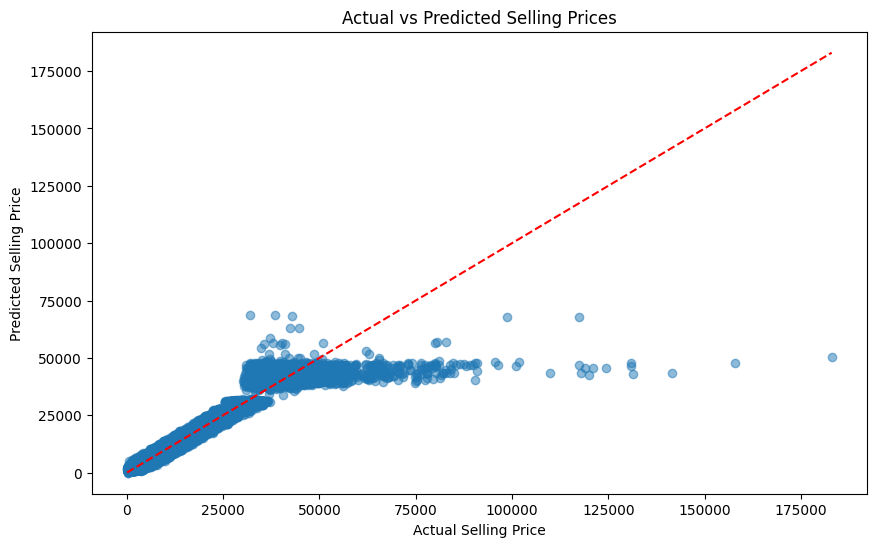

In [79]:
predictions_pd = predictions.select("sellingprice", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['sellingprice'], predictions_pd['prediction'], alpha=0.5)
plt.plot([predictions_pd['sellingprice'].min(), predictions_pd['sellingprice'].max()],
         [predictions_pd['sellingprice'].min(), predictions_pd['sellingprice'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Prices')
plt.show()

#### Prediction using double + tanpa condition

24/06/21 22:10:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:10:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:10:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:10:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:10:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/21 22:10:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


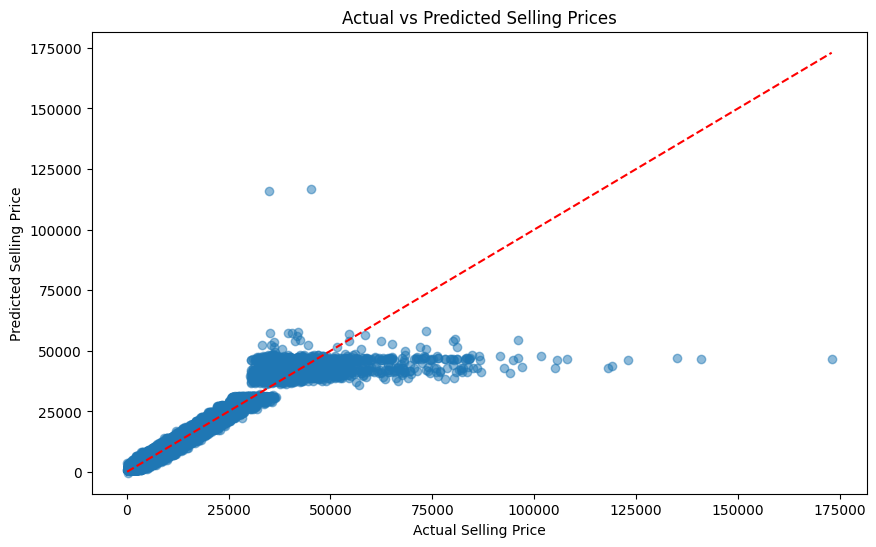

In [88]:
predictions_pd = predictions.select("sellingprice", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['sellingprice'], predictions_pd['prediction'], alpha=0.5)
plt.plot([predictions_pd['sellingprice'].min(), predictions_pd['sellingprice'].max()],
         [predictions_pd['sellingprice'].min(), predictions_pd['sellingprice'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Prices')
plt.show()

#### Prediction using double scaling + normalisation log

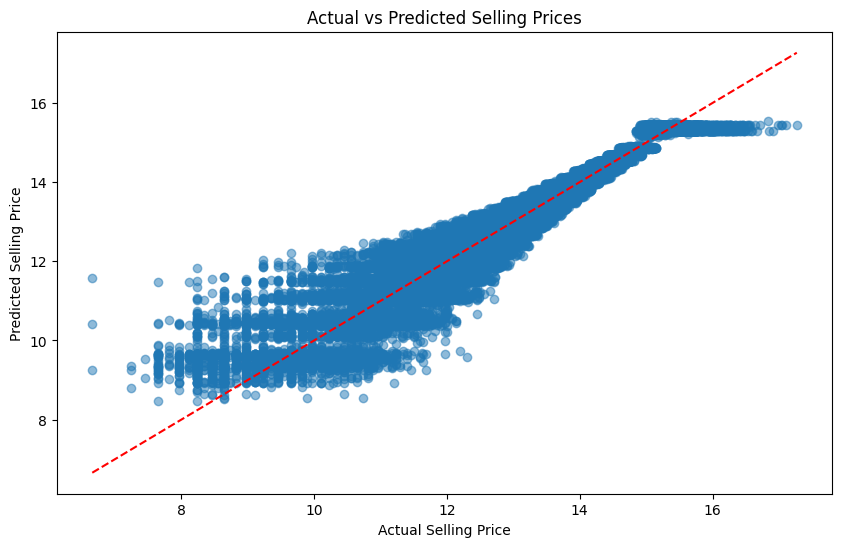

In [36]:
predictions_pd = predictions_final.select("sellingprice_log2", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['sellingprice_log2'], predictions_pd['prediction'], alpha=0.5)
plt.plot([predictions_pd['sellingprice_log2'].min(), predictions_pd['sellingprice_log2'].max()],
         [predictions_pd['sellingprice_log2'].min(), predictions_pd['sellingprice_log2'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Prices')
plt.show()

In [100]:
spark.stop()